# Identify generic genes and pathways

This notebook performs the following steps to identify generic genes
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.

3. For each gene, aggregate statsitics across all simulated experiments 
4. Rank genes based on this aggregated statistic

**Evaluation:**
We want to compare our ranking using ponyo, compared to the ranking found from Crow et. al.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from sklearn.decomposition import PCA

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import calc, process

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_compendium_file = params['normalized_compendium_data_file']
scaler_file = params['scaler_transform_file']
col_to_rank = params['col_to_rank']
compare_genes = params['compare_genes']
statistic = params['gsea_statistic']

gene_summary_file = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_gene_summary_{project_id}.tsv")

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

# Load metadata file with grouping assignments for samples
sample_id_metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv")

# Load pickled file
scaler = pickle.load(open(scaler_file, "rb"))

### Simulate experiments using selected template experiment

In [4]:
# Simulate multiple experiments
for i in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_compendium_file,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        i)

Instructions for updating:
Colocations handled automatically by placer.


Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](../explore_data/0_explore_input_data.ipynb)

In [5]:
if os.path.exists(sample_id_metadata_file):
    # Read in metadata
    metadata = pd.read_csv(sample_id_metadata_file, sep='\t', header=0, index_col=0)
    
    # Get samples to be dropped
    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)

    process.subset_samples(sample_ids_to_drop,
                           num_runs,
                           local_dir,
                           project_id)

In [6]:
# Round compendium read counts to int
#process.recast_int(num_runs, local_dir, project_id)

### Differential expression analysis

In [7]:
# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    project_id+"_groups.tsv")

In [8]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("DESeq2")

NULL


In [9]:
%%R
# Load the DESeq2 library
suppressPackageStartupMessages(library("DESeq2"))

In [10]:
# Check ordering of sample ids is consistent between gene expression data and metadata
process.check_sample_ordering(template_data_file, metadata_file)

sample ids are ordered correctly


In [11]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../generic_expression_patterns_modules/DE_analysis.R')

get_DE_stats_DESeq(metadata_file,
             project_id, 
             template_data_file,
             "template",
             local_dir,
             "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarni

[1] "Checking sample ordering..."
[1] TRUE


In [12]:
# Check number of DEGs
template_DE_stats_file = os.path.join(
        local_dir,
        "DE_stats",
        f"DE_stats_template_data_{project_id}_real.txt")

template_DE_stats = pd.read_csv(template_DE_stats_file, sep="\t", header=0, index_col=0)

selected = template_DE_stats[(template_DE_stats['padj']<0.01) & (abs(template_DE_stats['log2FoldChange'])>1)]
print(selected.shape)

(3283, 6)


In [13]:
# Check ordering of sample ids is consistent between gene expression data and metadata
for i in range(num_runs):
    simulated_data_file = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt")
        
    process.check_sample_ordering(simulated_data_file, metadata_file)

sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly
sample ids are ordered correctly


In [14]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs

source('../generic_expression_patterns_modules/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    get_DE_stats_DESeq(metadata_file,
                       project_id, 
                       simulated_data_file,
                       "simulated",
                       local_dir,
                       i)
}

[1] "Checking sample ordering..."
[1] TRUE
Error in DESeqDataSet(se, design = design, ignoreRank) : 
  some values in assay are not integers


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in DESeqDataSet(se, design = design, ignoreRank) : 
  some values in assay are not integers

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: package ‘matrixStats’ was built under R version 3.6.3 

  warnings.warn(x, RRuntimeWarning)


**Validation:**
* As a quick validation, [Kim et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3566005/) found 1459 DEGs (543 upregulated and 916 downregulated) using used the Bowtie and NEUMA applications for the mapping and quantification of RNA-Seq data. They used *edgeR* with a rigorous filtering procedure based on false discovery rates, minimum applicable patient numbers, and gene expression levels was devised to select reliable sets of DEGs and DEIs (see File S8 for details). For the

* Our results found ~3K DEGs which is close enough in range given that the data was processed using different methods. recount2 resource were aligned with the splice-aware Rail-RNA aligner

### Rank genes

In [15]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id)

print(simulated_DE_stats_all.shape)

(444700, 7)


In [16]:
# Take absolute value of logFC and t statistic
simulated_DE_stats_all = process.abs_value_stats(simulated_DE_stats_all)

In [17]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(col_to_rank,
                                                  simulated_DE_stats_all)

In [18]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

# Take absolute value of logFC and t statistic
template_DE_stats = process.abs_value_stats(template_DE_stats)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes(col_to_rank,
                                   template_DE_stats,
                                   True)

In [19]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes(col_to_rank,
                                            simulated_DE_summary_stats,
                                            False)

### Gene summary table

In [20]:
summary_gene_ranks = process.generate_summary_table(template_DE_stats,
                                                   simulated_DE_summary_stats,
                                                   col_to_rank,
                                                   local_dir)

summary_gene_ranks.head()

(17788, 13)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PAX7,PAX7,5.947105e-13,17601.0,10.693976,0.093447,12395.0,0.736720,0.626895,25,15.883459
PRAME,PRAME,2.957595e-15,17600.0,8.664826,0.000081,14911.0,1.321843,1.072240,25,6.848266
SLCO1B3,SLCO1B3,5.295483e-04,17599.0,8.325555,0.027025,14926.0,1.193922,1.007753,25,7.076763
KCNC2,KCNC2,1.984730e-10,17598.0,8.230400,0.018207,13818.0,1.223429,1.217960,24,5.753040
HOTAIR,HOTAIR,3.121660e-10,17597.0,8.228151,0.000001,16366.0,1.899140,1.462285,25,4.328165


In [21]:
summary_gene_ranks.to_csv(
    gene_summary_file, sep='\t')

### GSEA 
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. In this case we used the p-value scores to rank genes. logFC returned error -- need to look into this.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

In [22]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("GSA")
#BiocManager::install("fgsea")

NULL


In [23]:
%%R
suppressPackageStartupMessages(library("GSA"))
suppressPackageStartupMessages(library("fgsea"))

In [24]:
# Load pathway data
hallmark_DB_file = os.path.join(
    local_dir,
    "hallmark_DB.gmt")

   SHROOM4     NPC1L1        DEK     PTPN18      THOC1      TRPV5 
-1.6743446  3.6619220  0.3014608 -0.1258702  0.1982916  1.0146279 
     PAX7     PRAME   SLCO1B3     KCNC2    HOTAIR    HOXB13 
10.693976  8.664826  8.325555  8.230400  8.228151  8.197587 
$HALLMARK_ADIPOGENESIS
  [1] "ABCA1"    "ABCB8"    "ACAA2"    "ACADL"    "ACADM"    "ACADS"   
  [7] "ACLY"     "ACO2"     "ACOX1"    "ADCY6"    "ADIG"     "ADIPOQ"  
 [13] "ADIPOR2"  "AGPAT3"   "AGPAT6"   "AIFM1"    "AK2"      "ALDH2"   
 [19] "ALDOA"    "ANGPT1"   "ANGPTL4"  "ANKRD57"  "APLP2"    "APOE"    
 [25] "ARAF"     "ARL4A"    "ATL2"     "ATP1B3"   "ATP5O"    "BAZ2A"   
 [31] "BCKDHA"   "BCL2L13"  "BCL6"     "C3"       "CAT"      "CCNG2"   
 [37] "CD151"    "CD302"    "CD36"     "CDKN2C"   "CHCHD10"  "CHUK"    
 [43] "CIDEA"    "CMBL"     "CMPK1"    "COL15A1"  "COL4A1"   "COQ3"    
 [49] "COQ5"     "COQ9"     "COX6A1"   "COX7B"    "COX8A"    "CPT2"    
 [55] "CRAT"     "CS"       "CYC1"     "CYP4B1"   "DBT"      "DDT"     
 

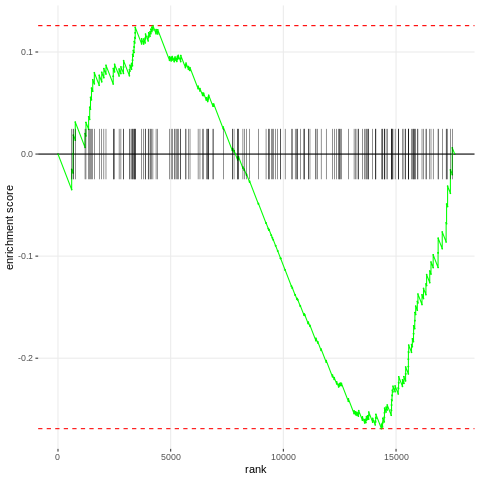

In [25]:
%%R -i template_DE_stats_file -i hallmark_DB_file -i statistic
# This cell is temporary and contains the same code as the GSEA_analysis.R file
# This is being used to debug the GSEA results found
# Read in data
DE_stats_data <- read.table(template_DE_stats_file, sep="\t", header=TRUE, row.names=NULL)

# feature 1: numeric vector
if (statistic == 'logFC'){
    col_num = 2
} else if (statistic == 'log2FoldChange'){
    col_num = 3
} else if (statistic =='t'){
    col_num = 4
} else if (statistic == 'p-value'){
    col_num = 5
} else if (statistic == 'adj p-value' || statistic == 'pvalue'){
    col_num = 6
} else if ( statistic == 'padj'){
    col_num = 7
}

rank_genes <- as.numeric(as.character(DE_stats_data[,col_num]))

# feature 2: named vector of gene ids
names(rank_genes) <- as.character(DE_stats_data[,1])
print(head(rank_genes))
## feature 3: decreasing order
rank_genes <- sort(rank_genes, decreasing = TRUE)
print(head(rank_genes))

pathway_DB_data <- gmtPathways(hallmark_DB_file)
print(head(pathway_DB_data))

#print(head(pathway_DB_data))
# GSEA is a generic gene set enrichment function
# Different backend methods can be applied depending on the 
# type of annotations
# Here we will use fgsea

#enrich_pathways <- fgsea(pathways=pathway_DB_data,
#                         stats=rank_genes,
#                         nperm=10000,
#                         minSize=10,
#                         maxSize=200
#                        )

#print(enrich_pathways)

# Look at those pathways WITH significant padj
#plotEnrichment(pathway_DB_data[["HALLMARK_TNFA_SIGNALING_VIA_NFKB"]], stats=rank_genes, gseaParam = 1, ticksSize = 0.2)
#plotEnrichment(pathway_DB_data[["HALLMARK_TNFA_SIGNALING_VIA_NFKB"]], stats=rank_genes, gseaParam = 1, ticksSize = 0.2)

# Look at those pathways with NOT significant padj
plotEnrichment(pathway_DB_data[["HALLMARK_P53_PATHWAY"]], stats=rank_genes, gseaParam = 1, ticksSize = 0.2)
#barplot(sort(rank_genes, decreasing = T))"""

In [26]:
%%R -i template_DE_stats_file -i hallmark_DB_file -i statistic -o template_enriched_pathways

source('../generic_expression_patterns_modules/GSEA_analysis.R')
template_enriched_pathways <- find_enriched_pathways(template_DE_stats_file, hallmark_DB_file, statistic)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


## Quick validation
Significant pathways found include: HALLMARK_G2M_CHECKPOINT, TNFA_SIGNALING, INFLAMMATORY_RESPONSE, APOPTOSIS, HYPOXIA are expected and consistent with what the publication found. However, there are pathways not found to be significant that we would expect to find: P53, NOTCH_SIGNALING, DNA_REPAIR. Not sure how to explain this since the enrichment score plot looks consistent with the p-value score .

In [27]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways['padj'] < 0.05].sort_values(by='padj')

(50, 8)


,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
12,HALLMARK_E2F_TARGETS,0.000124,0.002067,0.545636,1.931533,0.0,185,None
17,HALLMARK_G2M_CHECKPOINT,0.000124,0.002067,0.544469,1.926753,0.0,184,None
18,HALLMARK_GLYCOLYSIS,0.000123,0.002067,0.518884,1.847292,0.0,196,None
1,HALLMARK_ALLOGRAFT_REJECTION,0.000505,0.002233,-0.393586,-1.607390,0.0,180,None
44,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.000536,0.002233,-0.672227,-2.779854,0.0,197,None
33,HALLMARK_MYOGENESIS,0.000529,0.002233,-0.438236,-1.809286,0.0,195,None
26,HALLMARK_INTERFERON_GAMMA_RESPONSE,0.000516,0.002233,-0.379584,-1.553062,0.0,185,None
24,HALLMARK_INFLAMMATORY_RESPONSE,0.000536,0.002233,-0.522611,-2.161147,0.0,197,None
23,HALLMARK_IL6_JAK_STAT3_SIGNALING,0.000358,0.002233,-0.489332,-1.801412,0.0,85,None
22,HALLMARK_IL2_STAT5_SIGNALING,0.000524,0.002233,-0.433946,-1.789448,0.0,193,None


In [28]:
template_enriched_pathways[template_enriched_pathways['padj'] >= 0.05].sort_values(by='padj')

,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
28,HALLMARK_KRAS_SIGNALING_UP,0.020032,0.052715,-0.312396,-1.286807,37.0,192,None
48,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.022183,0.055458,-0.466124,-1.505951,75.0,42,None
4,HALLMARK_APICAL_JUNCTION,0.023364,0.055630,-0.309774,-1.276107,44.0,191,None
0,HALLMARK_ADIPOGENESIS,0.029306,0.066604,-0.306933,-1.260631,56.0,187,None
7,HALLMARK_BILE_ACID_METABOLISM,0.058684,0.127573,-0.324908,-1.244921,147.0,110,None
19,HALLMARK_HEDGEHOG_SIGNALING,0.090858,0.189288,-0.433641,-1.325577,325.0,33,None
49,HALLMARK_XENOBIOTIC_METABOLISM,0.109034,0.202964,-0.278462,-1.147116,209.0,191,None
9,HALLMARK_COAGULATION,0.109601,0.202964,-0.297246,-1.169042,257.0,131,None
15,HALLMARK_ESTROGEN_RESPONSE_LATE,0.105869,0.202964,0.340342,1.207342,854.0,191,None
42,HALLMARK_SPERMATOGENESIS,0.120351,0.214912,0.359222,1.220537,918.0,129,None


In [29]:
template_enriched_pathways.set_index('pathway', inplace=True)
template_enriched_pathways.loc["HALLMARK_P53_PATHWAY"]

pval            0.178146
padj            0.288871
ES              -0.26905
NES             -1.10505
nMoreExtreme         343
size                 189
leadingEdge         None
Name: HALLMARK_P53_PATHWAY, dtype: object

In [30]:
# Check expression of TP53 genes in cancer vs normal samples
tp53_genes = list(template_DE_stats[list(template_DE_stats.index.str.find("TP53") == 0)].index)
template_data = pd.read_csv(template_data_file, sep="\t", index_col=0)

selected_template_data = template_data[tp53_genes]

In [31]:
# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    "data",
    "metadata",
    project_id+"_groups.tsv")

# Read metadata
metadata = pd.read_csv(
    metadata_file,
    header=0,
    sep='\t',
    index_col=0)

In [32]:
# PCA encode
pca = PCA(n_components=2)

model = pca.fit(selected_template_data)
template_PCAencoded = model.transform(selected_template_data)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded ,
                                         index=template_data.index,
                                         columns=['1','2'])

In [33]:
# Add tumor/normal labels
template_data_labeled = pd.merge(template_PCAencoded_df, metadata, left_index=True, right_index=True)
template_data_labeled.loc[template_data_labeled['group'] == 1,'source'] = 'Normal'
template_data_labeled.loc[template_data_labeled['group'] == 2,'source'] = 'Tumor'
template_data_labeled.head()

,1,2,group,source
SRR493937,-2140.792769,-403.785169,1,Normal
SRR493938,-2208.978078,-297.952672,1,Normal
SRR493939,1225.263002,-1727.728274,2,Tumor
SRR493940,1327.831701,-1581.425770,2,Tumor
SRR493941,654.404034,1152.789906,1,Normal


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


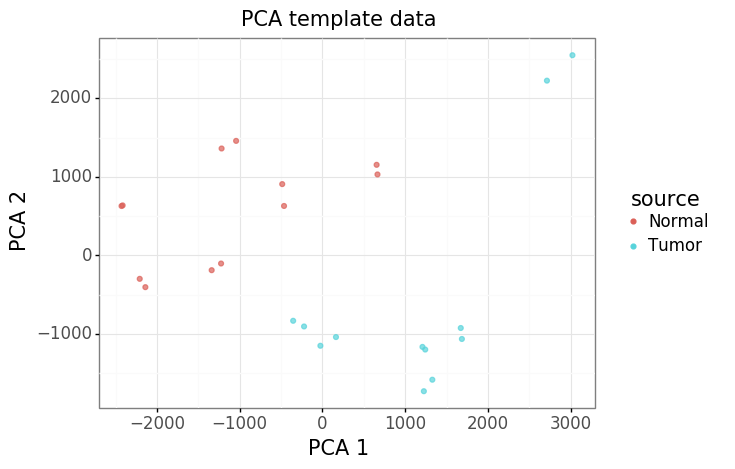

<ggplot: (8748370892777)>


In [34]:
# Plot
fig = ggplot(template_data_labeled, aes(x='1', y='2'))
fig += geom_point(aes(color='source'), alpha=0.7)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA template data')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)

In [37]:
%%R -i project_id -i local_dir -i hallmark_DB_file -i num_runs -i statistic

source('../generic_expression_patterns_modules/GSEA_analysis.R')

for (i in 0:(num_runs-1)){
    simulated_DE_stats_file <- paste(local_dir, 
                                 "DE_stats/DE_stats_simulated_data_", 
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    out_file = paste(local_dir, 
                     "GSEA_stats/GSEA_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep="")
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_file, hallmark_DB_file, statistic) 
    
    write.table(data.frame(enriched_pathways), file = out_file, row.names = T, sep = "\t")
    }


Error in write.table(data.frame(enriched_pathways), file = out_file, row.names = T,  : 
  unimplemented type 'list' in 'EncodeElement'


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in write.table(data.frame(enriched_pathways), file = out_file, row.names = T,  : 
  unimplemented type 'list' in 'EncodeElement'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In readLines(gmt.file) :
  warnings.warn(x,

### Rank pathways 

### Pathway summary table

### Compare gene ranking
Studies have found that there are some genes that are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represents a more systematic change. 

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

0.28613028665195755 0.0 0.2730587033424329 0.300136195598018


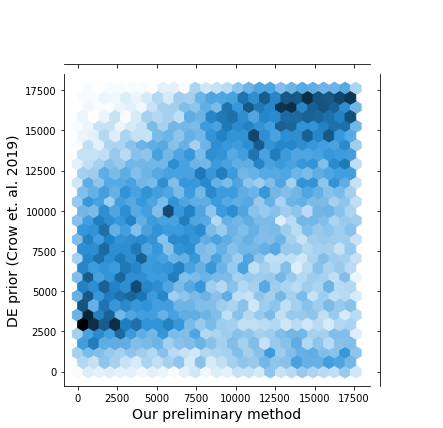

In [36]:
if compare_genes:
    # Get generic genes identified by Crow et. al.
    DE_prior_file = params['reference_gene_file']
    ref_gene_col = params['reference_gene_name_col']
    ref_rank_col = params['reference_rank_col']
    
    # Merge our ranking and reference ranking
    shared_gene_rank_df = process.merge_ranks_to_compare(
        summary_gene_ranks,
        DE_prior_file,
        ref_gene_col,
        ref_rank_col)
    
    if max(shared_gene_rank_df["Rank (simulated)"]) != max(shared_gene_rank_df[ref_rank_col]):
        shared_gene_rank_scaled_df = process.scale_reference_ranking(shared_gene_rank_df, ref_rank_col)
        
    # Drop genes with 0 mean base expression
    # Note: These lowly expressed genes were not pre-filtered before DESeq
    # (Micheal Love, author of DESeq2): In our DESeq2 paper we discuss a case where estimation of dispersion is difficult 
    # for genes with very, very low average counts. See the methods. 
    # However it doesn't really effect the outcome because these genes have almost no power for detecting 
    # differential expression. Effects runtime though.
    shared_gene_rank_scaled_df = shared_gene_rank_scaled_df[~shared_gene_rank_scaled_df['Rank (simulated)'].isna()]
    
    # Get correlation
    r, p, ci_high, ci_low = calc.spearman_ci(0.95,
                                             shared_gene_rank_scaled_df,
                                             1000)
    print(r, p, ci_high, ci_low)
    
    # Plot our ranking vs published ranking
    fig_file = os.path.join(
        local_dir, 
        "gene_ranking_"+col_to_rank+".svg")

    fig = sns.jointplot(data=shared_gene_rank_scaled_df,
                        x='Rank (simulated)',
                        y=ref_rank_col,
                        kind='hex',
                        marginal_kws={'color':'white'})
    fig.set_axis_labels("Our preliminary method", "DE prior (Crow et. al. 2019)", fontsize=14)

    fig.savefig(fig_file,
                format='svg',
                bbox_inches="tight",
                transparent=True,
                pad_inches=0,
                dpi=300,)

**Takeaway:**
Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies). These results serve to validate that our method can be used to identify these generic genes, as we were able to recapitulate the some of the generic genes as those identified by Crow et. al. Additionally, our method extends the Crow et. al. work, which used array data, and since here we used RNA-seq.

### Compare pathway ranking